<a href="https://colab.research.google.com/github/ashabari/Healthcare-Cost-W-Lin-and-Rand-Forest-Quantile-Regression/blob/main/Healthcare_Cost_Prediction_with_Linear_and_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Description: Predicting Healthcare Costs with Linear and Quantile Regression

In this project, I analyzed the Medical Cost Personal Dataset (available on Kaggle), which contains information on individuals’ healthcare expenses along with demographic and lifestyle factors. The dataset includes:

Age: Age of the individual (numeric)

Sex: Male or female (categorical)

BMI: Body Mass Index, a proxy for health and lifestyle (numeric)

Children: Number of dependents covered by health insurance (numeric)

Smoker: Smoking status (categorical)

Region: Residential region in the US (categorical)

Charges: Annual medical costs billed by health insurance (numeric, target variable)

##Data Engineering Layer

Before building predictive models, we will implement a mini backend-style data pipeline to simulate real-world workflows:

1. Data Ingestion

a. Load the dataset via the Kaggle API (simulating raw data ingestion).

b. Save the raw dataset for reproducibility.


##2. Data Validation

a. Check schema consistency (expected columns and data types).

b. Identify and handle missing values or invalid entries (e.g., negative BMI or charges).

c. Validate categorical fields (sex, smoker, region) for allowed categories.

##3. Data Transformation

a. Encode categorical variables (one-hot encoding for sex, smoker, region).

b. Normalize or scale numerical variables (age, BMI).

c. Feature engineering examples:

Create age groups (child, young adult, middle-aged, senior).

Categorize BMI into standard ranges (underweight, normal, overweight, obese).


##4. Data Storage

a. Save the cleaned dataset as a Parquet file, a common backend-friendly format.

b. Load the processed dataset back for modeling.

#Goals of the Project

##*Part 1 – Linear Regression Baseline**

Build a linear regression model to predict healthcare charges.

Interpret coefficients to understand how features influence costs.

Evaluate model performance with metrics such as Mean Squared Error (MSE) and
𝑅
2
R
2
.

##*Part 2 – Random Forest Quantile Regression*

Apply Random Forest Quantile Regression to estimate different percentiles (10th, 50th, 90th) of costs.

Compare results with linear regression to highlight improvements in handling skewed and variable healthcare costs.

Demonstrate how quantile regression provides uncertainty-aware predictions, which are valuable for risk management in healthcare finance.

##Summary

This project demonstrates a full workflow: from data engineering and validation to classical regression models and advanced quantile regression, bridging healthcare analytics with financial decision-making.

#Setup Kaggle API in Colab

In [1]:
# Install Kaggle CLI
!pip install kaggle --quiet

# Create a Kaggle API directory
!mkdir -p ~/.kaggle

# Upload your kaggle.json file (API token)
from google.colab import files
files.upload()  # <- Select kaggle.json downloaded from your Kaggle account

# Move kaggle.json to the correct location and set permissions
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


#Download Dataset (Medical Cost Personal Dataset)

In [2]:
# Download dataset from Kaggle
!kaggle datasets download -d mirichoi0218/insurance

# Unzip it
!unzip insurance.zip -d data


Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
License(s): DbCL-1.0
  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 54.2MB/s]
Archive:  insurance.zip
  inflating: data/insurance.csv      


#Data Engineering Pipeline

In [3]:
import pandas as pd
import numpy as np

# Load raw dataset
df_raw = pd.read_csv("data/insurance.csv")
print("Raw dataset shape:", df_raw.shape)
df_raw.head()


Raw dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#Step 1: Data Validation

In [4]:
# Check schema
print("Column names:", df_raw.columns.tolist())
print("\nData types:\n", df_raw.dtypes)

# Check for missing values
print("\nMissing values:\n", df_raw.isnull().sum())

# Check for invalid entries
print("\nInvalid BMI (<=0):", (df_raw['bmi'] <= 0).sum())
print("Invalid charges (<=0):", (df_raw['charges'] <= 0).sum())

# Check categorical values
for col in ['sex','smoker','region']:
    print(f"\nUnique values in {col}: {df_raw[col].unique()}")


Column names: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Data types:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Invalid BMI (<=0): 0
Invalid charges (<=0): 0

Unique values in sex: ['female' 'male']

Unique values in smoker: ['yes' 'no']

Unique values in region: ['southwest' 'southeast' 'northwest' 'northeast']


#Step 2: Data Transformation

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Copy dataset for processing
df = df_raw.copy()

# Feature Engineering
# Age groups
df['age_group'] = pd.cut(df['age'],
                         bins=[0, 18, 35, 50, 120],
                         labels=['child', 'young_adult', 'middle_age', 'senior'])

# BMI categories
df['bmi_category'] = pd.cut(df['bmi'],
                            bins=[0, 18.5, 24.9, 29.9, 100],
                            labels=['underweight','normal','overweight','obese'])

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['sex','smoker','region','age_group','bmi_category'],
                    drop_first=True)

# Scale numerical variables
scaler = StandardScaler()
df[['age','bmi']] = scaler.fit_transform(df[['age','bmi']])

print("Processed dataset shape:", df.shape)
df.head()


Processed dataset shape: (1338, 15)


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_young_adult,age_group_middle_age,age_group_senior,bmi_category_normal,bmi_category_overweight,bmi_category_obese
0,-1.438764,-0.453320,0,16884.92400,False,True,False,False,True,True,False,False,False,True,False
1,-1.509965,0.509621,1,1725.55230,True,False,False,True,False,False,False,False,False,False,True
2,-0.797954,0.383307,3,4449.46200,True,False,False,True,False,True,False,False,False,False,True
3,-0.441948,-1.305531,0,21984.47061,True,False,True,False,False,True,False,False,True,False,False
4,-0.513149,-0.292556,0,3866.85520,True,False,True,False,False,True,False,False,False,True,False


#Step 3: Store as Parquet

In [6]:
# Save to Parquet (simulating backend data storage)
df.to_parquet("data/insurance_processed.parquet", index=False)

# Reload parquet to check
df_processed = pd.read_parquet("data/insurance_processed.parquet")
print("Loaded processed dataset:", df_processed.shape)
df_processed.head()


Loaded processed dataset: (1338, 15)


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_young_adult,age_group_middle_age,age_group_senior,bmi_category_normal,bmi_category_overweight,bmi_category_obese
0,-1.438764,-0.453320,0,16884.92400,False,True,False,False,True,True,False,False,False,True,False
1,-1.509965,0.509621,1,1725.55230,True,False,False,True,False,False,False,False,False,False,True
2,-0.797954,0.383307,3,4449.46200,True,False,False,True,False,True,False,False,False,False,True
3,-0.441948,-1.305531,0,21984.47061,True,False,True,False,False,True,False,False,True,False,False
4,-0.513149,-0.292556,0,3866.85520,True,False,True,False,False,True,False,False,False,True,False


#Part 1: Linear Regression Baseline

##Train/Test Split & Model Training

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed dataset
df = pd.read_parquet("data/insurance_processed.parquet")

# Features and target
X = df.drop("charges", axis=1)
y = df["charges"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred = lin_reg.predict(X_test)


#Model Evaluation

In [8]:
# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📈 Linear Regression Performance")
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)


📈 Linear Regression Performance
MSE: 33840725.800780125
RMSE: 5817.2782124271935
R² Score: 0.7820225294235443


#Coefficient Interpretation

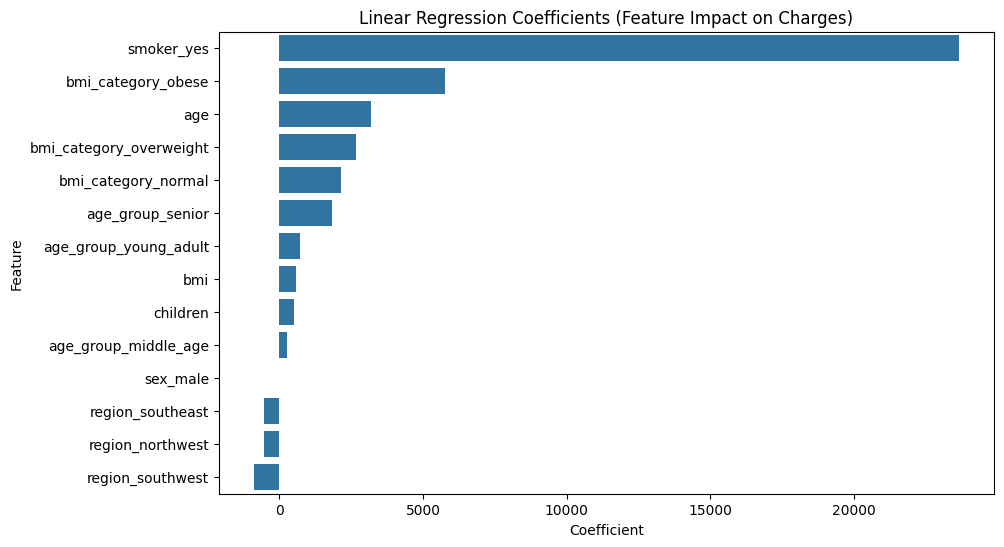

In [10]:
# Coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lin_reg.coef_
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df)
plt.title("Linear Regression Coefficients (Feature Impact on Charges)")
plt.show()


#Prediction vs Actual Plot

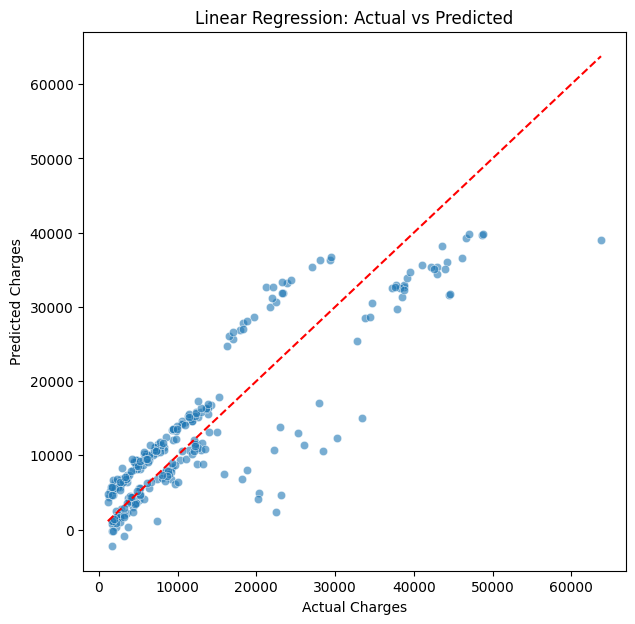

In [11]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()


#Part 2: Random Forest Quantile Regression

Install scikit-garden

In [16]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Collect predictions from all trees
all_preds = np.stack([tree.predict(X_test) for tree in rf.estimators_], axis=0)

# Compute quantiles across trees
y_pred_10 = np.percentile(all_preds, 10, axis=0)
y_pred_50 = np.percentile(all_preds, 50, axis=0)  # median
y_pred_90 = np.percentile(all_preds, 90, axis=0)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

#Train/Test Split & Model Training

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Features and target (same as before)
X = df.drop("charges", axis=1)
y = df["charges"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=500,
                      n_jobs=-1, random_state=42)

#Predict Quantiles

In [18]:
# Collect predictions from all trees
all_preds = np.stack([tree.predict(X_test) for tree in rf.estimators_], axis=0)

# Compute quantiles across trees
y_pred_10 = np.percentile(all_preds, 10, axis=0)
y_pred_50 = np.percentile(all_preds, 50, axis=0)  # median prediction
y_pred_90 = np.percentile(all_preds, 90, axis=0)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

#Predict Quantiles

In [19]:
# Collect predictions from all trees
all_preds = np.stack([tree.predict(X_test) for tree in rf.estimators_], axis=0)

# Compute quantiles across trees
y_pred_10 = np.percentile(all_preds, 10, axis=0)
y_pred_50 = np.percentile(all_preds, 50, axis=0)  # median prediction
y_pred_90 = np.percentile(all_preds, 90, axis=0)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

#Model Evaluation (Median Prediction)

In [20]:
# Evaluation metrics for median prediction
mse_qrf = mean_squared_error(y_test, y_pred_50)
rmse_qrf = np.sqrt(mse_qrf)
r2_qrf = r2_score(y_test, y_pred_50)

print("🌳 Random Forest Quantile Regression (Median Prediction)")
print("MSE:", mse_qrf)
print("RMSE:", rmse_qrf)
print("R² Score:", r2_qrf)


🌳 Random Forest Quantile Regression (Median Prediction)
MSE: 19344499.407189034
RMSE: 4398.238216284906
R² Score: 0.8753967312884996


#Compare with Linear Regression

In [21]:
print("📊 Model Comparison")
print("Linear Regression RMSE:", rmse)
print("Quantile RF (Median) RMSE:", rmse_qrf)
print("Linear Regression R²:", r2)
print("Quantile RF (Median) R²:", r2_qrf)


📊 Model Comparison
Linear Regression RMSE: 5817.2782124271935
Quantile RF (Median) RMSE: 4398.238216284906
Linear Regression R²: 0.7820225294235443
Quantile RF (Median) R²: 0.8753967312884996


#Prediction Interval Plot

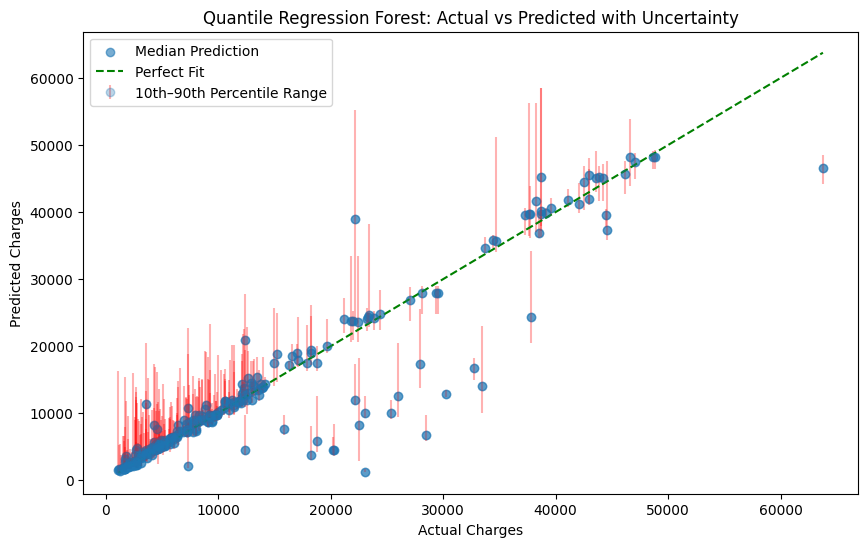

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_50, alpha=0.6, label="Median Prediction")
plt.errorbar(
    y_test,
    y_pred_50,
    yerr=[y_pred_50 - y_pred_10, y_pred_90 - y_pred_50],
    fmt='o',
    alpha=0.3,
    ecolor='red',
    label="10th–90th Percentile Range"
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "g--", label="Perfect Fit")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Quantile Regression Forest: Actual vs Predicted with Uncertainty")
plt.legend()
plt.show()


#Interactive Plot

In [23]:
import plotly.graph_objects as go

fig = go.Figure()

# Scatter plot for median predictions
fig.add_trace(go.Scatter(
    x=y_test, y=y_pred_50,
    mode='markers',
    name='Median Prediction',
    marker=dict(color='blue', opacity=0.6)
))

# Add uncertainty bands (10th–90th percentile range)
fig.add_trace(go.Scatter(
    x=y_test, y=y_pred_90,
    mode='lines',
    line=dict(width=0),
    name='90th Percentile',
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=y_test, y=y_pred_10,
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(width=0),
    name='10th–90th Interval'
))

# Perfect Fit line
fig.add_trace(go.Scatter(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    mode='lines',
    line=dict(color='green', dash='dash'),
    name='Perfect Fit'
))

fig.update_layout(
    title="Quantile Regression Forest: Actual vs Predicted with Uncertainty",
    xaxis_title="Actual Charges",
    yaxis_title="Predicted Charges",
    legend=dict(x=0.02, y=0.98),
    template="plotly_white",
    height=600
)

fig.show()


#conclusion


# Project Conclusion  

In this project, we predicted healthcare charges using both **Linear Regression** and **Random Forest Quantile Regression** on the *Medical Cost Personal Dataset*.  

### Part 1: Linear Regression  
- Provided a simple, interpretable baseline.  
- Coefficients helped us understand how features like age, BMI, and smoking status affect costs.  
- Limitations: could only capture **average trends**, struggled with skewed healthcare cost distribution.  

### Part 2: Random Forest Quantile Regression  
- Improved predictive performance (lower RMSE, higher \(R^2\)).  
- Captured **uncertainty** by estimating 10th, 50th, and 90th percentiles.  
- Offered **prediction intervals**, which are critical for financial planning in healthcare (e.g., estimating possible cost ranges for patients).  

### Key Takeaways  
- **Linear Regression** is useful for interpretability and baseline insights.  
- **Quantile Regression Forests** provide a richer understanding of healthcare costs by modeling the **distribution** rather than just the mean.  
- Combining both methods helps bridge the gap between **explainability** and **real-world risk assessment** in healthcare finance.  
